# Enviroment set up

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
FILE_PATH = "/gdrive/My Drive/Colab Notebooks/Master/Vision por Computador/Practica 1/" #Guillermo
#FILE_PATH = "/gdrive/MyDrive/Colab Notebooks/COM VIS/Practica 1/" #Antonio

# Imports

In [3]:
import glob

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import pickle


from tensorflow.keras.layers import Input, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, SeparableConv2D, MaxPooling2D, add, UpSampling2D, Cropping2D
from tensorflow.keras import Model, losses
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from keras.layers.merge import concatenate
from keras.initializers import GlorotNormal
from keras.models import load_model

from scipy.spatial.distance import euclidean

from sklearn.cluster import KMeans

# Data load

In [4]:
with open(FILE_PATH + 'binary_60x80.pkl', 'rb') as file:
    X = pickle.load(file)

In [5]:
X.shape

(44400, 80, 60, 3)

# Load weights

In [6]:
n_dimensions = 3

In [7]:
autoencoder = load_model(FILE_PATH + 'Results_' + str(n_dimensions) + 'dim/autoencoder.h5')
encoder = load_model(FILE_PATH + 'Results_' + str(n_dimensions) + 'dim/encoder.h5')

The feature descriptor of each image is generated using the encoder. This way we do a dimensionality reduction.

In [8]:
encoder_predictions = encoder.predict(X[:1000])

In [9]:
encoder_predictions.shape

(1000, 3)

In [10]:
autoencoder_reconstructions = autoencoder.predict(X[:500])

In [11]:
autoencoder_reconstructions.shape

(500, 80, 60, 3)

## Plotting reconstruction

In [ ]:
def plot_reconstruction(reconstructed_img_predictions, epoch, index_list, plot=False):
    f, axarr = plt.subplots(len(index_list), 2, figsize=(6, 12))
    f.suptitle('Epoch: ' + str(epoch), fontsize=16)

    axarr[0,0].set_title('Source image')
    axarr[0,1].set_title('Reconstructed image')


    for i, index in enumerate(index_list):
        axarr[i,0].imshow(X[index])
        axarr[i,1].imshow(reconstructed_img_predictions[index])

        axarr[i,0].get_xaxis().set_visible(False)
        axarr[i,0].get_yaxis().set_visible(False)
        axarr[i,1].get_xaxis().set_visible(False)
        axarr[i,1].get_yaxis().set_visible(False)

    if plot:
        plt.plot()
    plt.savefig(FILE_PATH + "Results/" + epoch + 'reconstruction_results.png')

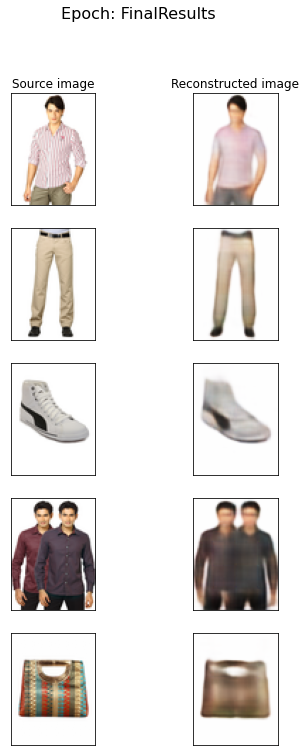

In [ ]:
plot_reconstruction(autoencoder_reconstructions, epoch='FinalResults', index_list=[1, 10, 150, 103, 240])

In [ ]:
f, axarr = plt.subplots(10, 1, figsize=(6, 60))

for i in range(10):
    axarr[i].imshow(X[i+250])

# Recommendation system

## Image distribution in space

Muestreo de la distribución espacial de los resúmenes de cada imágen, cabe destacar que cada imagen la representan sus 2 dimensiones

In [12]:
fig = go.Figure(data=[go.Scatter3d(x=encoder_predictions[:,0], y=encoder_predictions[:,1], z=encoder_predictions[:,2],
                                   mode='markers')])
fig.show()

## Recommendation via clustering

In [13]:
kmeans = KMeans(n_clusters = 6, random_state=0)
kmeans.fit(encoder_predictions)

KMeans(n_clusters=6, random_state=0)

In [14]:
clusters = kmeans.predict(encoder_predictions)

In [15]:
fig = go.Figure(data=[go.Scatter3d(x=encoder_predictions[:,0], y=encoder_predictions[:,1], z=encoder_predictions[:,2],
                                   mode='markers',
                                   marker=dict(size=6,
                                               color=clusters,                # set color to an array/list of desired values
                                               colorscale='Viridis',   # choose a colorscale
                                               opacity=1))])
fig.show()

In [ ]:
def clusters_full(cont_cluster, n_plots):
    for cluster in cont_cluster:
        if cluster < n_plots:
            return True

    return False

def plot_reconstruction_clusters(n_plots, n_clusters, imgs, clusters, plot=False):
    f, axarr = plt.subplots(n_clusters, n_plots, figsize=(3*n_plots, 3*n_clusters))
    cont = 0
    cont_cluster = [0 for i in range(n_clusters)]

    while clusters_full(cont_cluster, n_plots):
        if cont_cluster[clusters[cont]] < n_plots:
            axarr[clusters[cont], cont_cluster[clusters[cont]]].imshow(imgs[cont])
            axarr[clusters[cont], cont_cluster[clusters[cont]]].get_xaxis().set_visible(False)
            axarr[clusters[cont], cont_cluster[clusters[cont]]].get_yaxis().set_visible(False)
            
            cont_cluster[clusters[cont]] = cont_cluster[clusters[cont]]+1
        cont = cont+1

    if plot:
        plt.plot()
    plt.savefig(FILE_PATH + 'Results/recomendation_clusters_results.png')

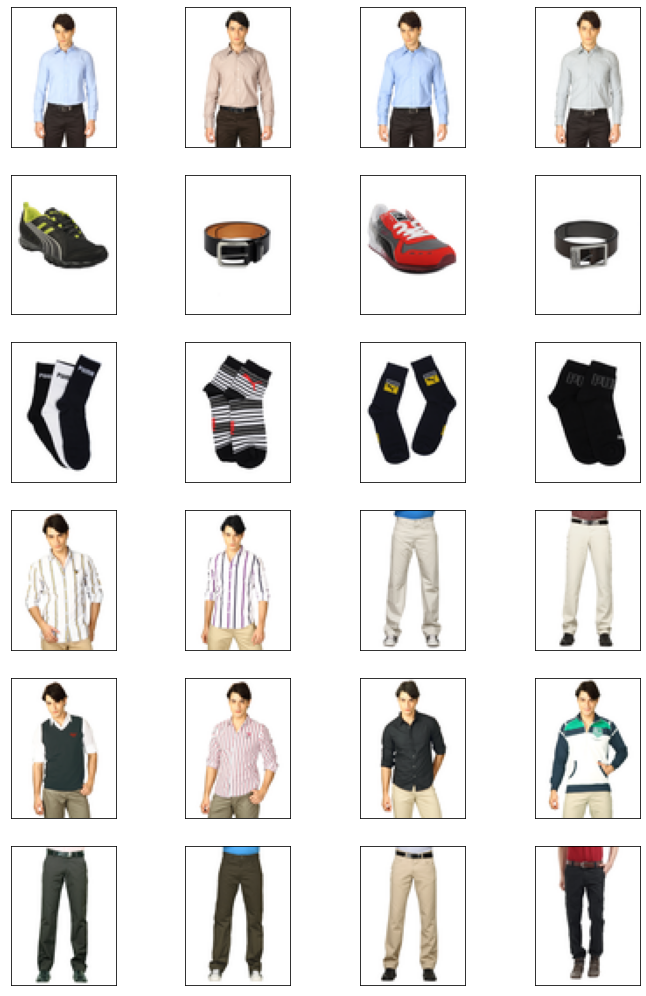

In [ ]:
plot_reconstruction_clusters(4, max(clusters)+1, X, clusters, plot=True)

## Neighbor list

In [ ]:
def find_nearest_neighbor_list(img_index, encoder_predictions):
    img = encoder_predictions[img_index]
    img_nneighbors = []
    distances = []
    cont = 0

    for candidate in encoder_predictions:
        if cont != img_index:
            distances.append(euclidean(img, candidate))
            img_nneighbors.append(cont)
        cont = cont+1

    return img_nneighbors, distances

In [ ]:
def plot_nearest_neighbor_list(reconstructed_img_predictions, img_index, dataset, num_neighbors, n):
    neighbor_list, distances = find_nearest_neighbor_list(img_index, reconstructed_img_predictions)

    f, axarr = plt.subplots(1, num_neighbors + 1, figsize=(3*num_neighbors, 4))

    f.suptitle('Nearest neighbors', fontsize=16)

    axarr[0].set_title('Source image')
    axarr[0].imshow(dataset[img_index])
    axarr[0].get_xaxis().set_visible(False)
    axarr[0].get_yaxis().set_visible(False)
    
    neighbors = zip(distances, neighbor_list)
    neighbors = sorted(neighbors)
    neighbors = list(neighbors)

    for i in range(num_neighbors):
        axarr[i+1].set_title('Dist: %.2f' % neighbors[i][0])
        axarr[i+1].imshow(dataset[neighbors[i][1]])
        axarr[i+1].get_xaxis().set_visible(False)
        axarr[i+1].get_yaxis().set_visible(False)

    plt.savefig(FILE_PATH + 'Results/nearest_' + str(num_neighbors) + 'neighbors_results' + str(n) + '.png')

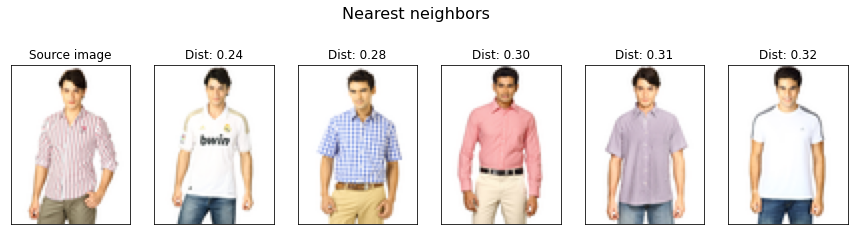

In [ ]:
plot_nearest_neighbor_list(encoder_predictions, 1, X[:1000], 5, 1)

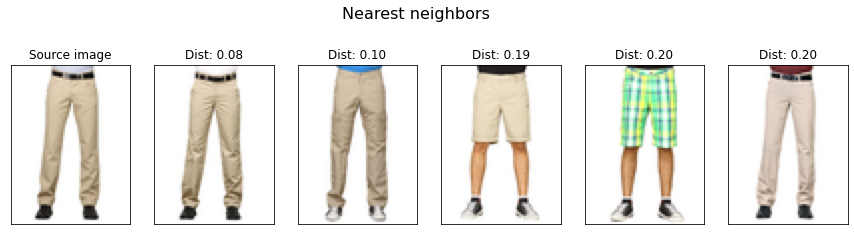

In [ ]:
plot_nearest_neighbor_list(encoder_predictions, 10, X[:1000], 5, 2)

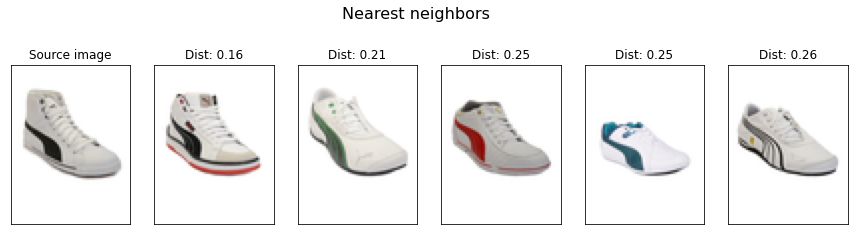

In [ ]:
plot_nearest_neighbor_list(encoder_predictions, 150, X[:1000], 5, 3)

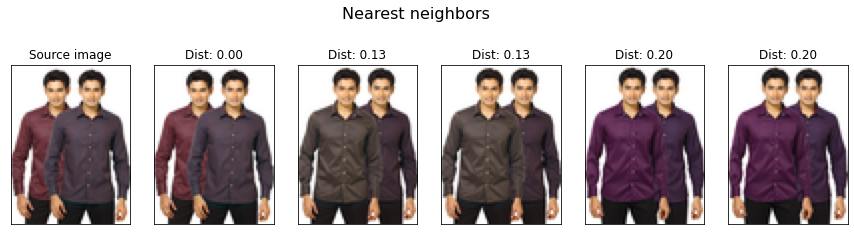

In [ ]:
plot_nearest_neighbor_list(encoder_predictions, 103, X[:1000], 5, 4)

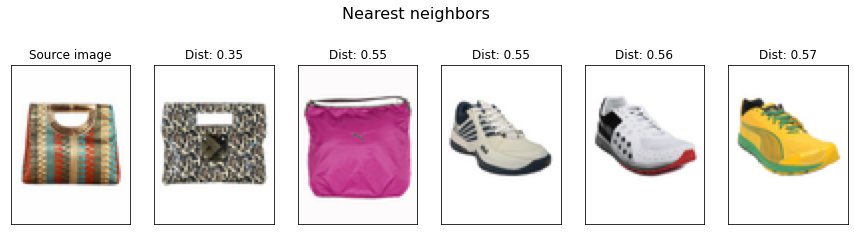

In [ ]:
plot_nearest_neighbor_list(encoder_predictions, 240, X[:1000], 5, 5)